In [1]:
###########################
#  Master thesis
# 
# UNIVERSITY: 
#  Faculty of Information Technology, Brno University of Technology
# 
# AUTHOR:
#  Aleš Kašpárek          <xkaspa48@stud.fit.vutbr.cz>
###########################

import os
import json
import math
import torch
import datetime
import graphviz

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import statsmodels.api as sm
import matplotlib.pyplot as plt

from math import sqrt
from torchview import draw_graph
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

graphviz.set_jupyter_format('png')

In [2]:
network_analytics = pd.read_csv('./data/Network_Analytics.csv')
series = pd.Series(network_analytics['OutboundUtilzation (%)'])

In [159]:
network_analytics.head()

,Timestamp,OutboundUtilzation (%)
0,10/10/2017 7:01,96.2442
1,10/10/2017 7:21,99.1131
2,10/10/2017 7:26,97.2892
3,10/10/2017 7:31,98.0286
4,10/10/2017 7:36,99.5263


[None, None, None, None, None, None, None, None]

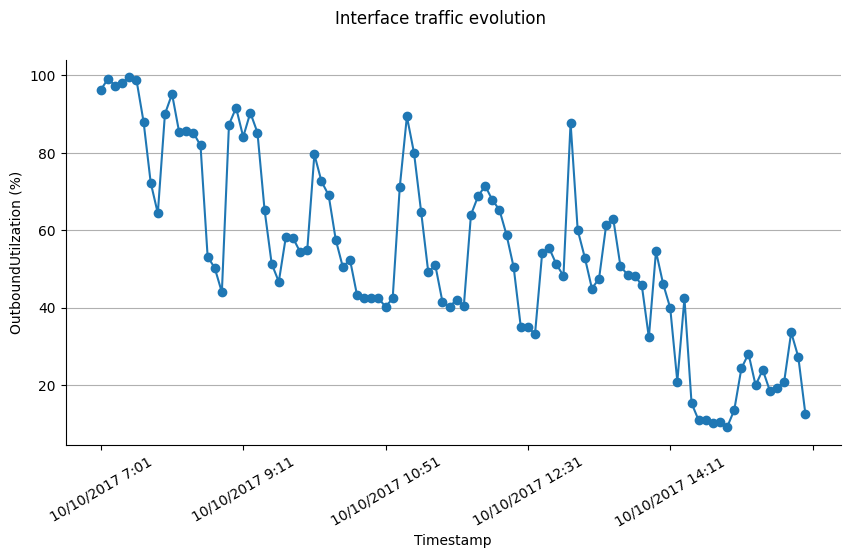

In [4]:
x = network_analytics['Timestamp'][:100]
y = network_analytics['OutboundUtilzation (%)'][:100]

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, y, marker='o')

fig.suptitle('Interface traffic evolution')
ax.set_ylabel('OutboundUtilzation (%)')
ax.set_xlabel('Timestamp')

ax.grid(True, axis='y')
ax.xaxis.set_major_locator(plt.MaxNLocator(6))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
[lab.set_rotation(30) for lab in ax.get_xticklabels()]

In [5]:
print(network_analytics['Timestamp'].max())
print(network_analytics['Timestamp'].min())
print(datetime.datetime.strptime(network_analytics['Timestamp'][len(network_analytics) - 1], '%d/%m/%Y %H:%M') - datetime.datetime.strptime(network_analytics['Timestamp'][0], '%d/%m/%Y %H:%M'))

12/9/2017 9:57
1/1/2018 0:02
295 days, 6:06:00


In [6]:
network_analytics.describe()

,OutboundUtilzation (%)
count,25631.000000
mean,60.372335
std,22.517275
min,0.000048
25%,44.873850
50%,62.100200
75%,77.702150
max,99.995500


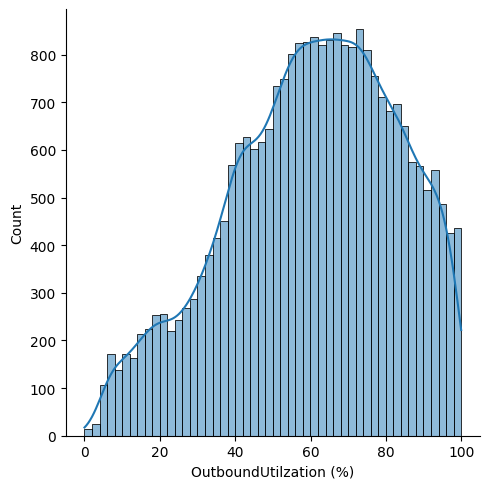

In [7]:
sns.displot(network_analytics['OutboundUtilzation (%)'], kde=True, bins=50)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

network_analytics = pd.read_csv('./data/Network_Analytics.csv')
series = pd.Series(network_analytics['OutboundUtilzation (%)'])

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
ax = sns.displot(data=network_analytics, x="OutboundUtilzation (%)", kind="hist", bins = 100, aspect = 1.5)
ax.set(
    xlabel='Outbound Utilization (%)'
)
plt.show()

2024-04-04 14:04:45.834 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED _fit distribution (taking more than 30 seconds)


2024-04-04 14:04:46.308 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.001389)
2024-04-04 14:04:46.877 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted anglit distribution with error=0.000821)
2024-04-04 14:04:47.017 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cosine distribution with error=0.000465)
2024-04-04 14:04:47.414 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted alpha distribution with error=0.157964)
2024-04-04 14:04:47.557 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted bradford distribution with error=0.002625)
2024-04-04 14:04:47.671 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted arcsine distribution with error=0.00556)
2024-04-04 14:04:47.705 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.007364)
2024-04-04 14:04:48.000 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted a

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,0.000198,972.277862,1004.884093,0.011919,0.021277,1.641867e-10
genextreme,0.000206,981.610517,1006.065190,0.015800,0.020445,9.741908e-10
argus,0.000224,967.091038,991.545711,0.012977,0.027767,1.334904e-17
burr12,0.000269,990.353799,1022.960030,0.019518,0.026515,4.354192e-16
weibull_min,0.000288,989.621284,1014.075958,0.020731,0.025029,2.217850e-14


/home/ales/.cache/pypoetry/virtualenvs/data-science-ChFJ_N9T-py3.11/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/ales/.cache/pypoetry/virtualenvs/data-science-ChFJ_N9T-py3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


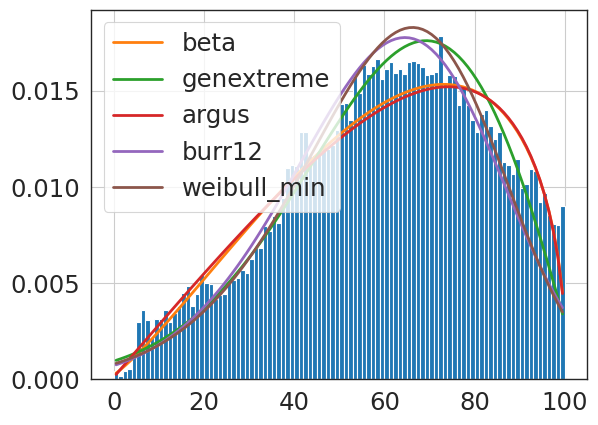

In [16]:
data = network_analytics['OutboundUtilzation (%)'].values

f = Fitter(data, distributions=get_distributions())
f.fit()
f.summary()

In [17]:
f.get_best(method = 'sumsquare_error')

{'beta': {'a': 2.2840246378455658,
  'b': 1.4660546616390748,
  'loc': -1.8357409964730569,
  'scale': 102.20562894315935}}

In [66]:
from scipy import stats

dist = stats.beta.pdf(2.2840246378455658, 1.4660546616390748, -1.8357409964730569, 102.20562894315935)
stats.kstest(data, 'beta', (2.2840246378455658, 1.4660546616390748, -1.8357409964730569, 102.20562894315935))

KstestResult(statistic=0.021276993681405676, pvalue=1.6418667607936974e-10, statistic_location=75.5084, statistic_sign=1)

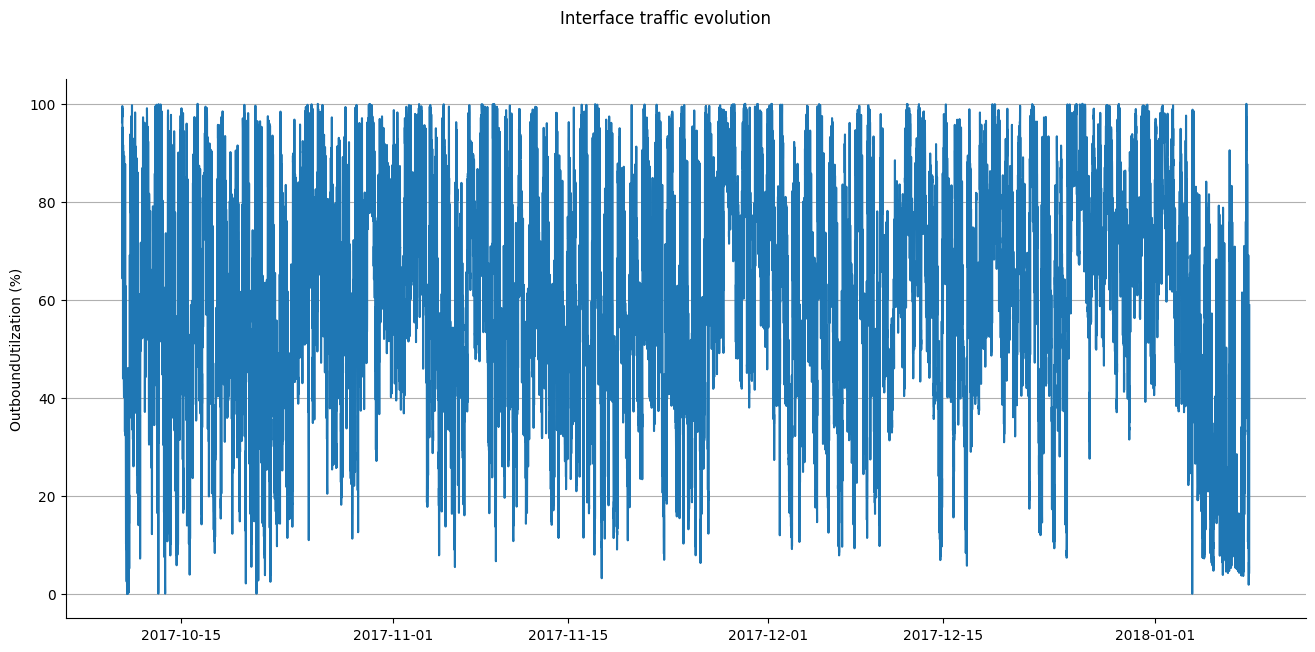

In [7]:
network_analytics['Timestamp']=pd.to_datetime(network_analytics['Timestamp'])
network_analytics_new = network_analytics.set_index('Timestamp')
network_analytics_new.rename(columns={'OutboundUtilzation (%)':'traffic_out'},inplace=True)  

x = network_analytics_new.index
y = network_analytics_new['traffic_out']

fig, ax = plt.subplots(figsize=(16, 7))

ax.plot(x, y)

fig.suptitle('Interface traffic evolution')
ax.set_ylabel('OutboundUtilzation (%)')

ax.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

/tmp/ipykernel_14988/2499562553.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  network_analytics_1H = network_analytics_new.resample('1H').mean()


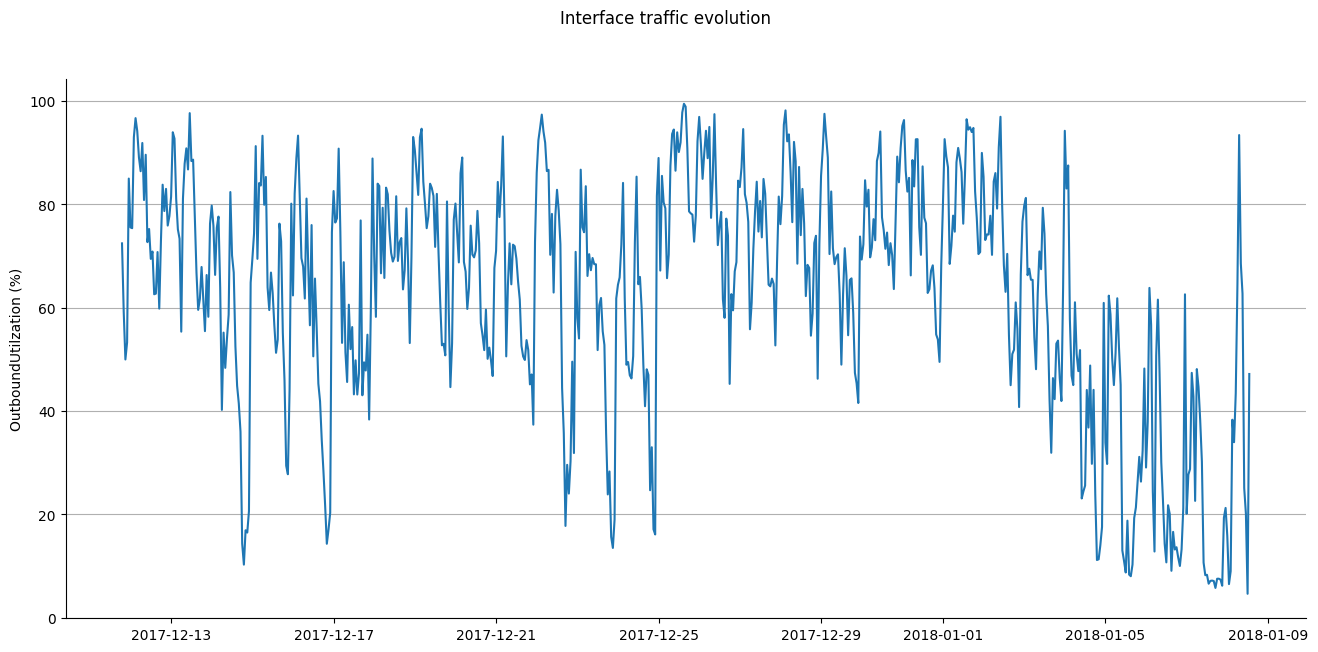

In [8]:
network_analytics_1H = network_analytics_new.resample('1H').mean()

x = network_analytics_1H.index[1500:]
y = network_analytics_1H[1500:]

fig, ax = plt.subplots(figsize=(16, 7))

ax.plot(x, y)

fig.suptitle('Interface traffic evolution')
ax.set_ylabel('OutboundUtilzation (%)')

ax.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

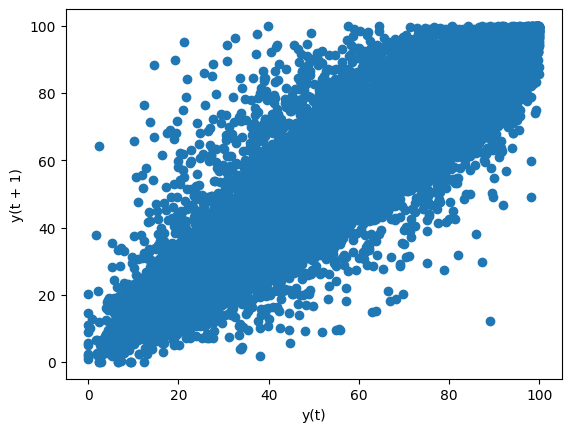

In [9]:
pd.plotting.lag_plot(series)

In [10]:
print(series.autocorr())

0.9229190122478933


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

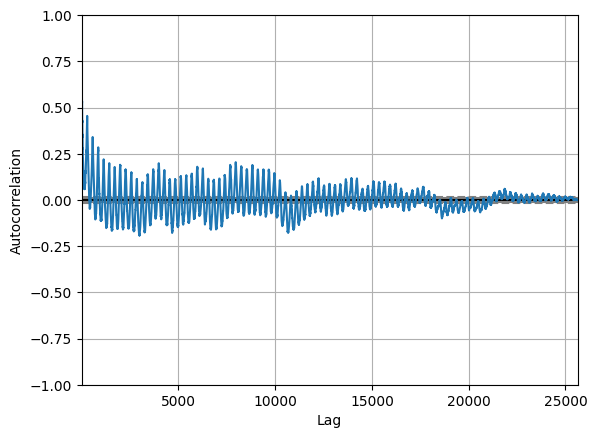

In [11]:
pd.plotting.autocorrelation_plot(series)

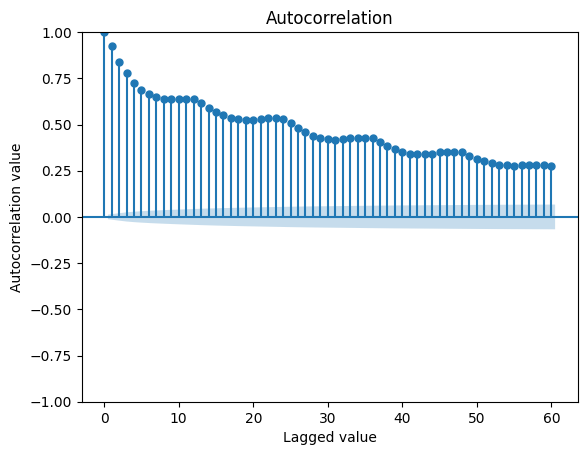

In [12]:
plot_acf(series, lags=60)
plt.ylabel("Autocorrelation value")
plt.xlabel("Lagged value")
plt.show()

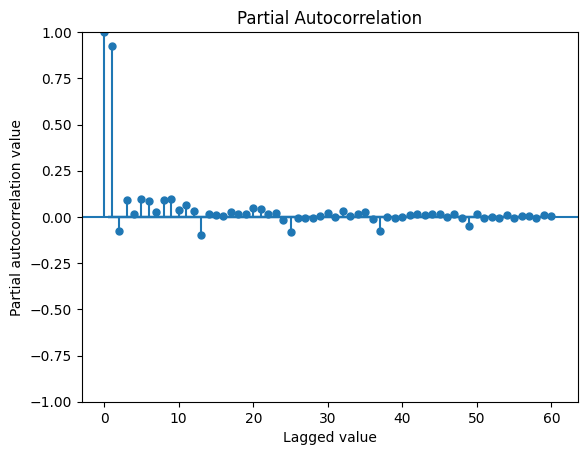

In [13]:
plot_pacf(series, lags=60)
plt.ylabel("Partial autocorrelation value")
plt.xlabel("Lagged value")
plt.show()

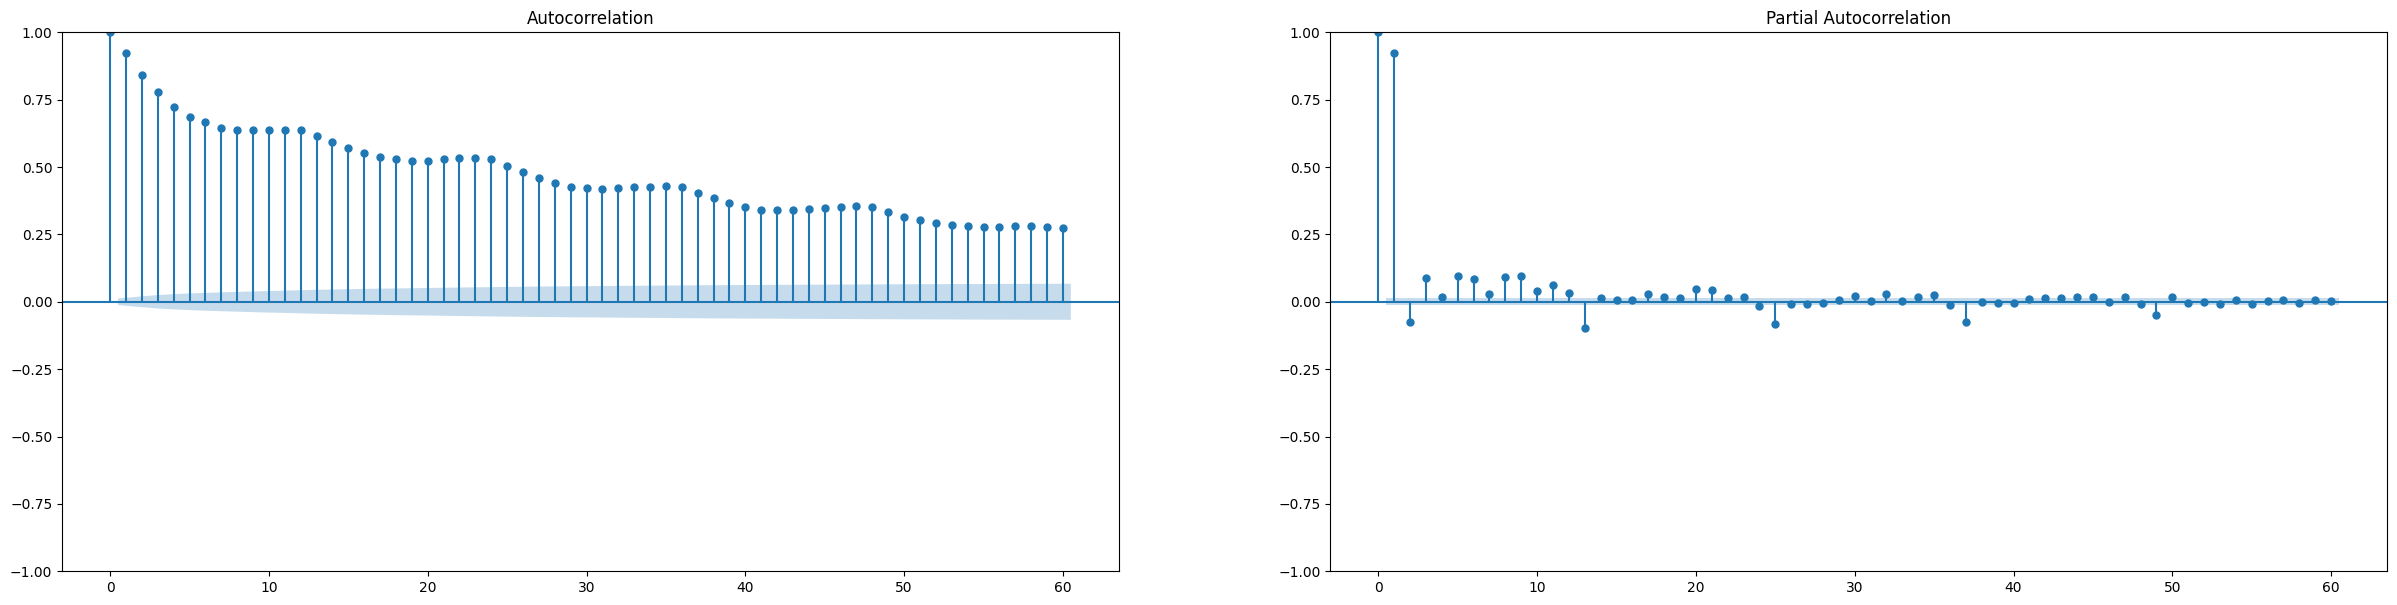

In [14]:
fig, ax = plt.subplots(1,2,figsize=(30,7))
sm.graphics.tsa.plot_acf(series, lags=60, ax=ax[0])
sm.graphics.tsa.plot_pacf(series, lags=60, ax=ax[1])
plt.show()

## Data preparation and utility function definition

In [3]:
def symmetric_mean_absolute_percentage_error(A, F):
    return 100/len(A) # np.sum(np.abs(F - A) / ((np.abs(A) + np.abs(F)) / 2))

In [4]:
def print_errors(usedlag, test, predictions, shape=True):
    if shape:
        test = test[:-1]
        predictions = predictions[1:]
    rmse = sqrt(mean_squared_error(test, predictions))
    print(f"RMSE for {usedlag}: {rmse}")

    mape = mean_absolute_percentage_error(test, predictions)
    print(f"MAPE for {usedlag}: {mape}")

    smape = symmetric_mean_absolute_percentage_error(test, predictions)
    print(f"SMAPE for {usedlag}: {smape}")

    mae = mean_absolute_error(test, predictions)
    print(f"MAE for {usedlag}: {mae}")

In [5]:
def plot_difference(test, predictions, dataset=network_analytics, shape=True):
    if shape:
        test = test[:-1]
        predictions = predictions[1:]
    fig, ax = plt.subplots(figsize=(15, 5))

    timestamps = [pd.Timestamp(x).strftime('%H:%M:%S') for x in dataset.Timestamp[-100:]]

    ax.plot(timestamps, test[len(test)- 100:], color='g', label='ground truth')
    ax.plot(timestamps, predictions[len(predictions) - 100:], color='r', label='predicted')
    plt.title('Difference between predicted and actual value')
    plt.xticks(timestamps[::12])
    plt.legend(loc='best')
    plt.ylabel('Outbound Utilization (%)')
    plt.xlabel('Timestamp')
    plt.show()

In [6]:
statistics, pval, ma_order, nobs, _, _ = adfuller(network_analytics['OutboundUtilzation (%)'], autolag='AIC')
if pval < 0.05:
    print(f"Data is stationary {statistics} {pval} {ma_order} {nobs}.")
else:
    print(f"Data is not stationary {statistics} {pval} {ma_order} {nobs}")

Data is stationary -12.704162687630873 1.0639878489319919e-23 49 25581.


In [7]:
X = series.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]

## MA model

Selected Order (p): 52


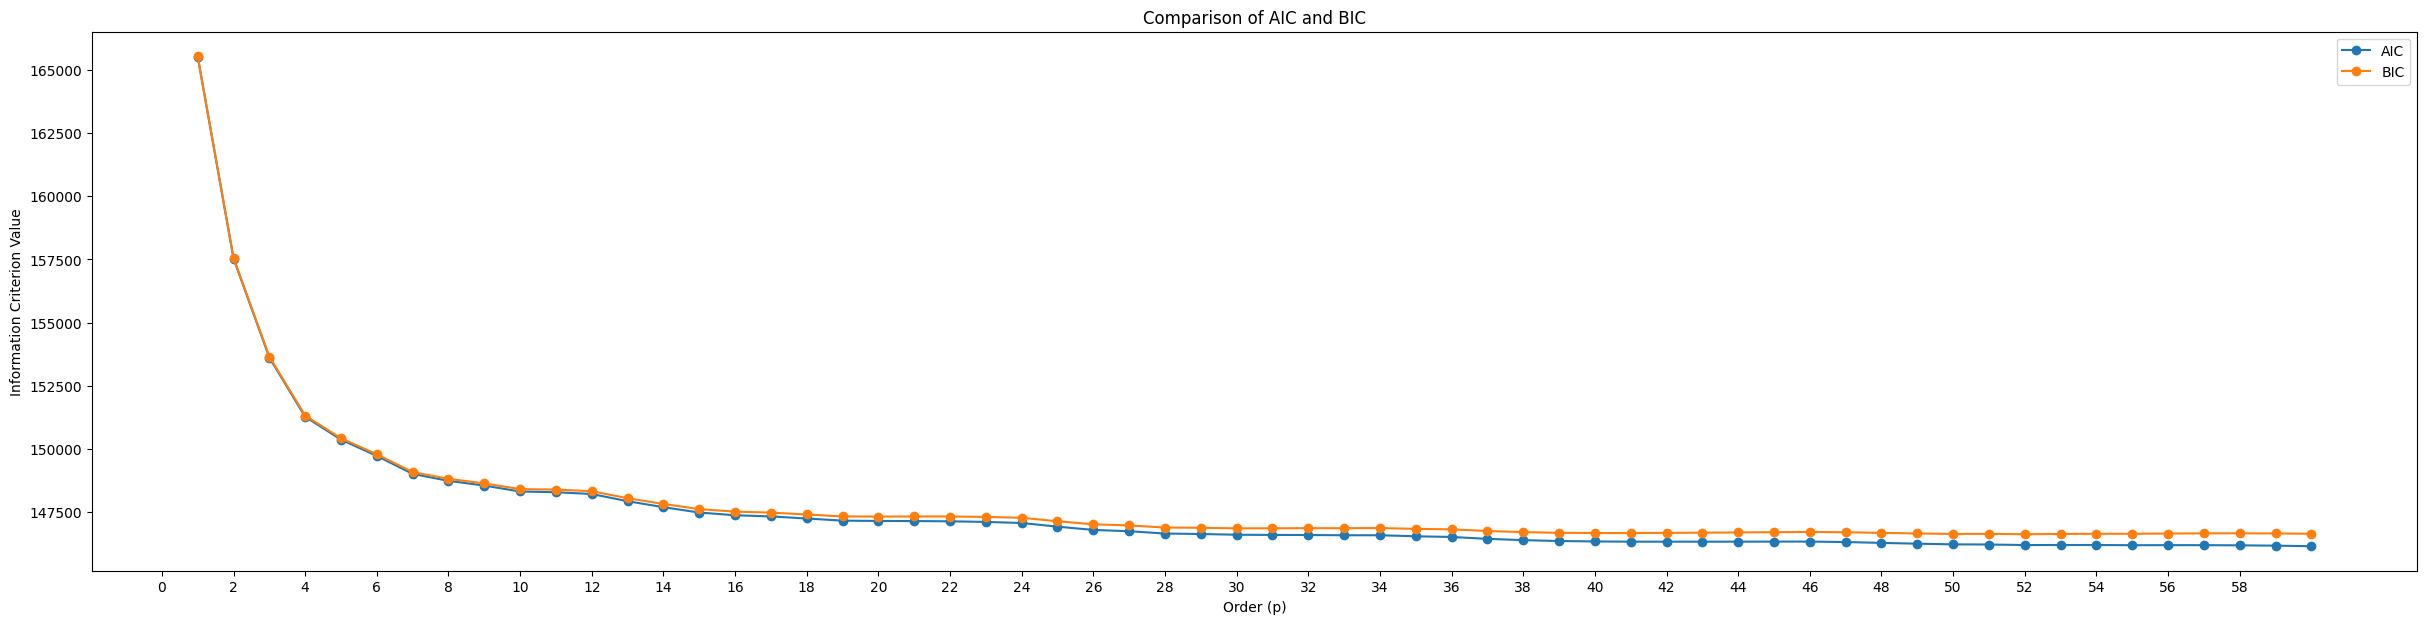

In [8]:
dir = 'outputs/information_criteria/MA/'

data = []
for file in os.listdir(dir):
    full_file_name = dir + file
    with open(full_file_name, 'r') as json_file:
        new_data = json.load(json_file)
    data.extend([dato for dato in new_data])
data = sorted(data, key=lambda x : x[0])
data = np.array(data)
aic_values = data[:,1]
bic_values = data[:,2]
p_values = data[:,3]

threshold = 0.05
ma_order = np.argmin(np.array(bic_values)) +  1
print("Selected Order (p):", ma_order)

plt.figure(figsize=(30,7))
plt.plot(range(1, len(data) + 1), aic_values, marker='o', label='AIC')
plt.plot(range(1, len(data) + 1), bic_values, marker='o', label='BIC')
plt.xlabel('Order (p)')
plt.ylabel('Information Criterion Value')
plt.title('Comparison of AIC and BIC')
plt.xticks(np.arange(0, len(data), 2.0))
plt.legend()
plt.show()

In [10]:
MA_model = ARIMA(endog=train, order=(0, 0, ma_order))
if os.path.isfile('models/MA.pkl'):
    results = ARIMAResults.load('models/MA.pkl')
    results.save('models/MA.pkl')
else:
    results = MA_model.fit()
# 5m 37s

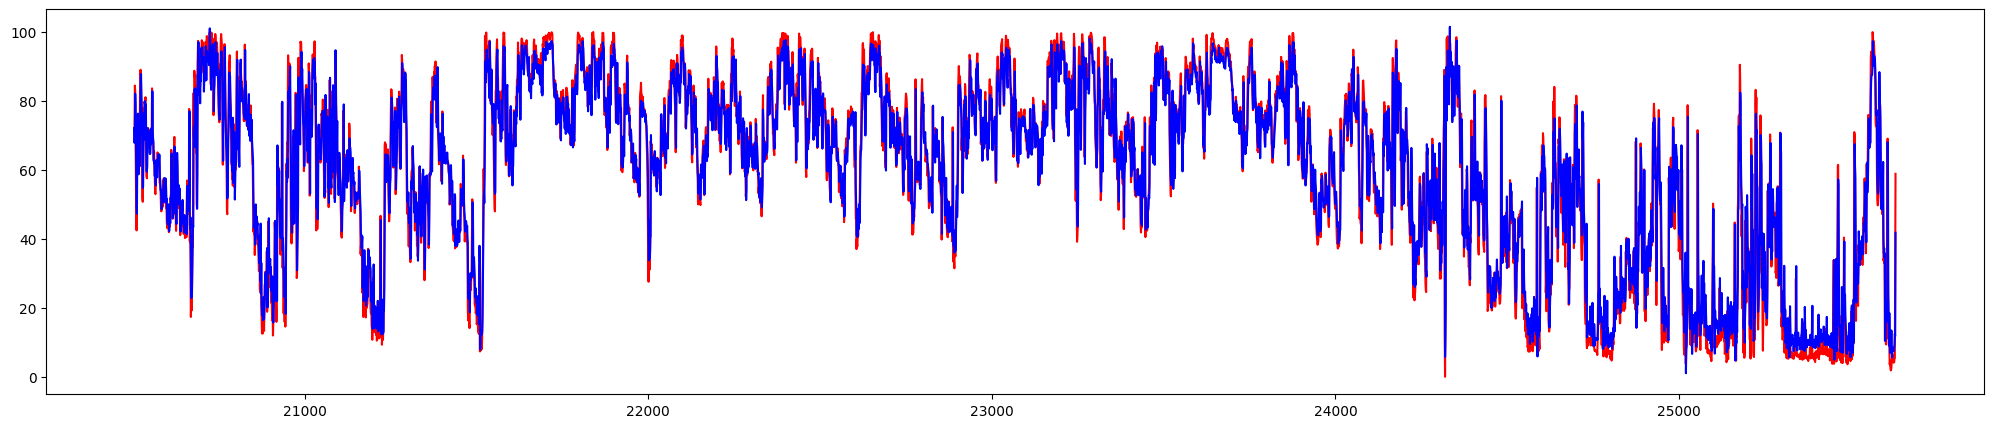

In [14]:
coef = results.params
# Grab last x values of the train dataset
history = train[len(train)-ma_order:]
# Compute their prediction
pred = results.predict(start=len(train) - ma_order + 1, end=len(train))
# Compute error between actual and prediction
errors = np.array(history - pred).tolist()

predictions = list()
for t in range(len(test)):
    yhat = coef[0]
    for d in range(ma_order):
        yhat += coef[d+1] # errors[ma_order-d-1]
        obs = X[t]
    predictions.append(yhat)

    errors.pop(0)
    errors.append(X[len(train) + t] - yhat)

fig, ax = plt.subplots(figsize=(25, 5))
ax.plot(range(size, len(network_analytics)),network_analytics['OutboundUtilzation (%)'][size:len(network_analytics)], color='r')
ax.plot(range(size, len(network_analytics)), predictions, color='b')

In [15]:
print_errors(ma_order, test, predictions)

RMSE for 49: 3.1025718049937034
MAPE for 49: 46.20997935325406
SMAPE for 49: 7.919287946905931
MAE for 49: 2.451961854215574


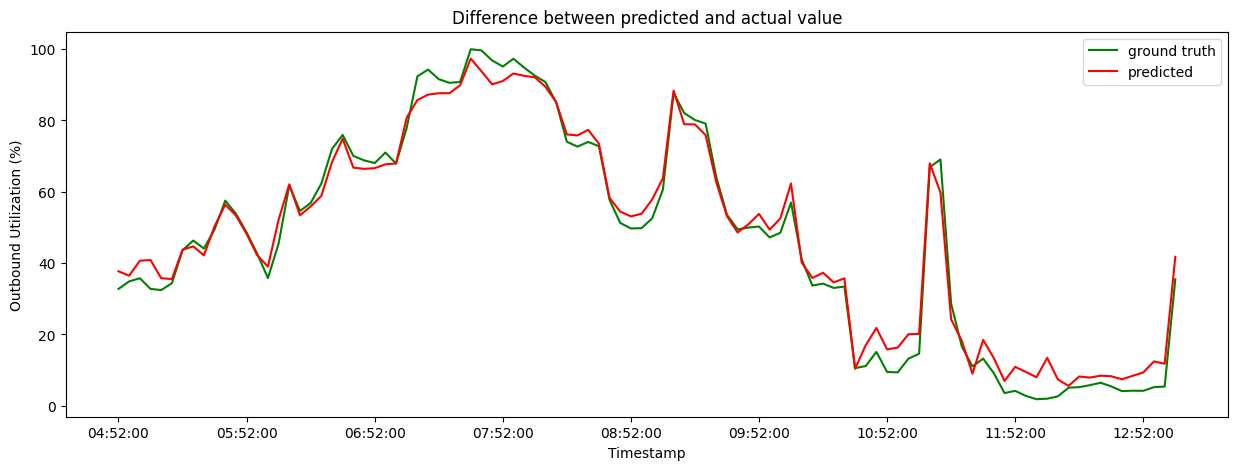

In [16]:
plot_difference(test, predictions)

## AR model

Selected Order (p): 307


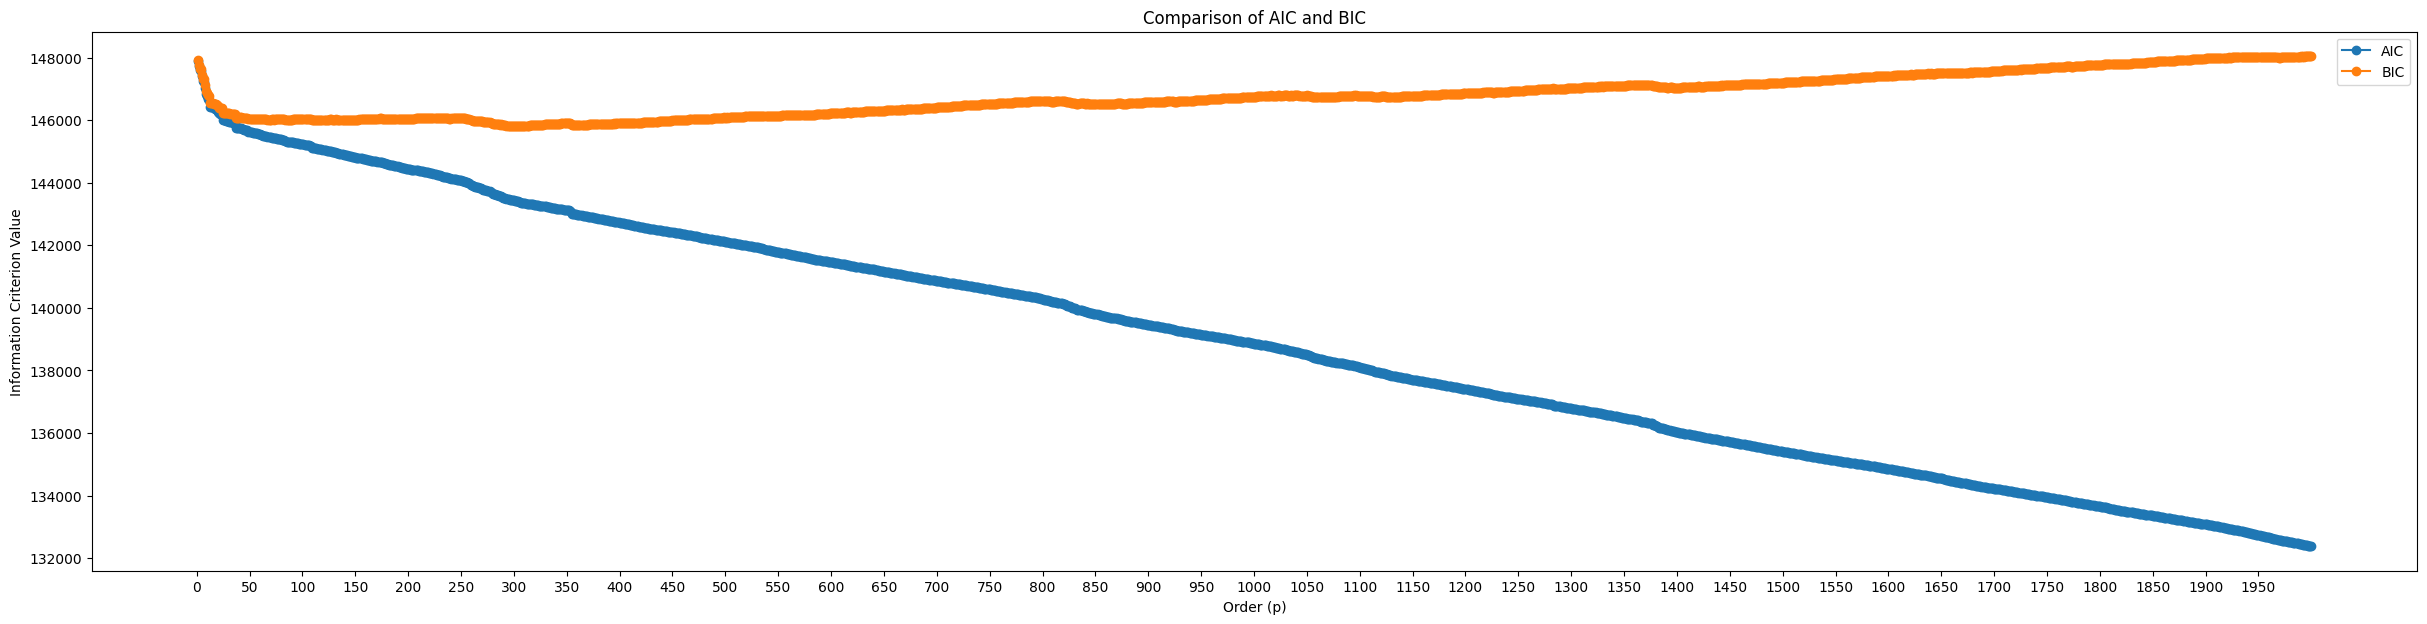

In [12]:
dir = 'outputs/information_criteria/AR'
with open(f"{dir}/criteria.json", 'r') as json_file:
    data = json.load(json_file)
data = sorted(data, key=lambda x : x[0])
data = np.array(data)
aic_values = data[:,1]
bic_values = data[:,2]
p_values = data[:,3]

ar_order = np.argmin(np.array(bic_values)) +  1
print("Selected Order (p):", ar_order)

plt.figure(figsize=(30,7))
plt.plot(range(1, len(data) + 1), aic_values, marker='o', label='AIC')
plt.plot(range(1, len(data) + 1), bic_values, marker='o', label='BIC')
plt.xlabel('Order (p)')
plt.ylabel('Information Criterion Value')
plt.title('Comparison of AIC and BIC')
plt.xticks(np.arange(0, len(data), 50.0))
plt.legend()
plt.show()

In [15]:
ar_order = 1

model = AutoReg(train, lags=ar_order)
model_fit = model.fit()
# 0s
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-ar_order:].tolist()
predictions = list()
for t in range(len(test)):
    length = len(history)
    yhat = coef[0]
    for d in range(ar_order):
        yhat += coef[d+1] # history[d]
        obs = X[t]
    predictions.append(yhat)
    history.pop(0)
    history.append(obs)

In [19]:
print_errors(ar_order, test, predictions)

RMSE for 1: 34.015406873527596
MAPE for 1: 92.93680986765901
SMAPE for 1: 55.50274840055562
MAE for 1: 27.824881219377172


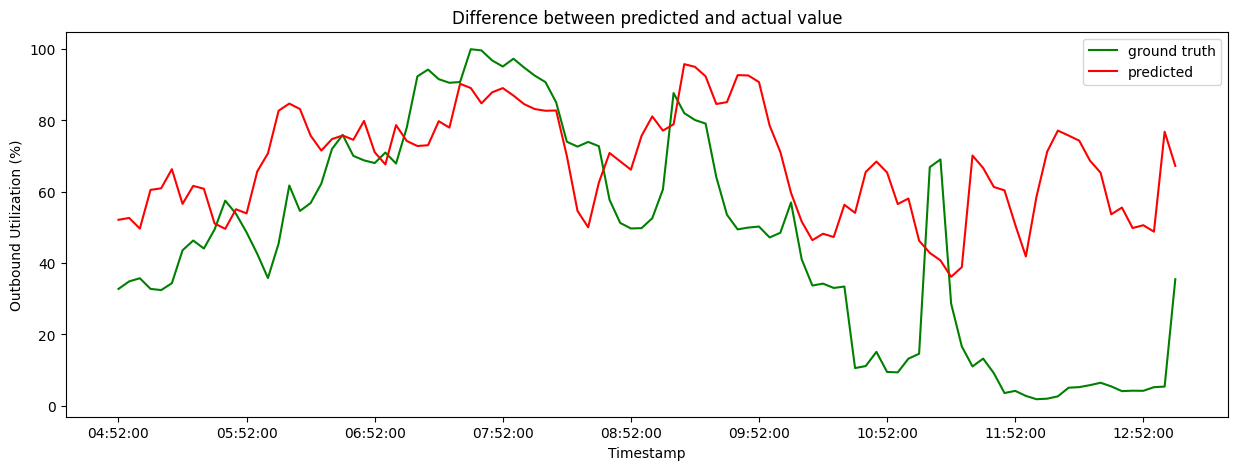

In [172]:
plot_difference(test, predictions)

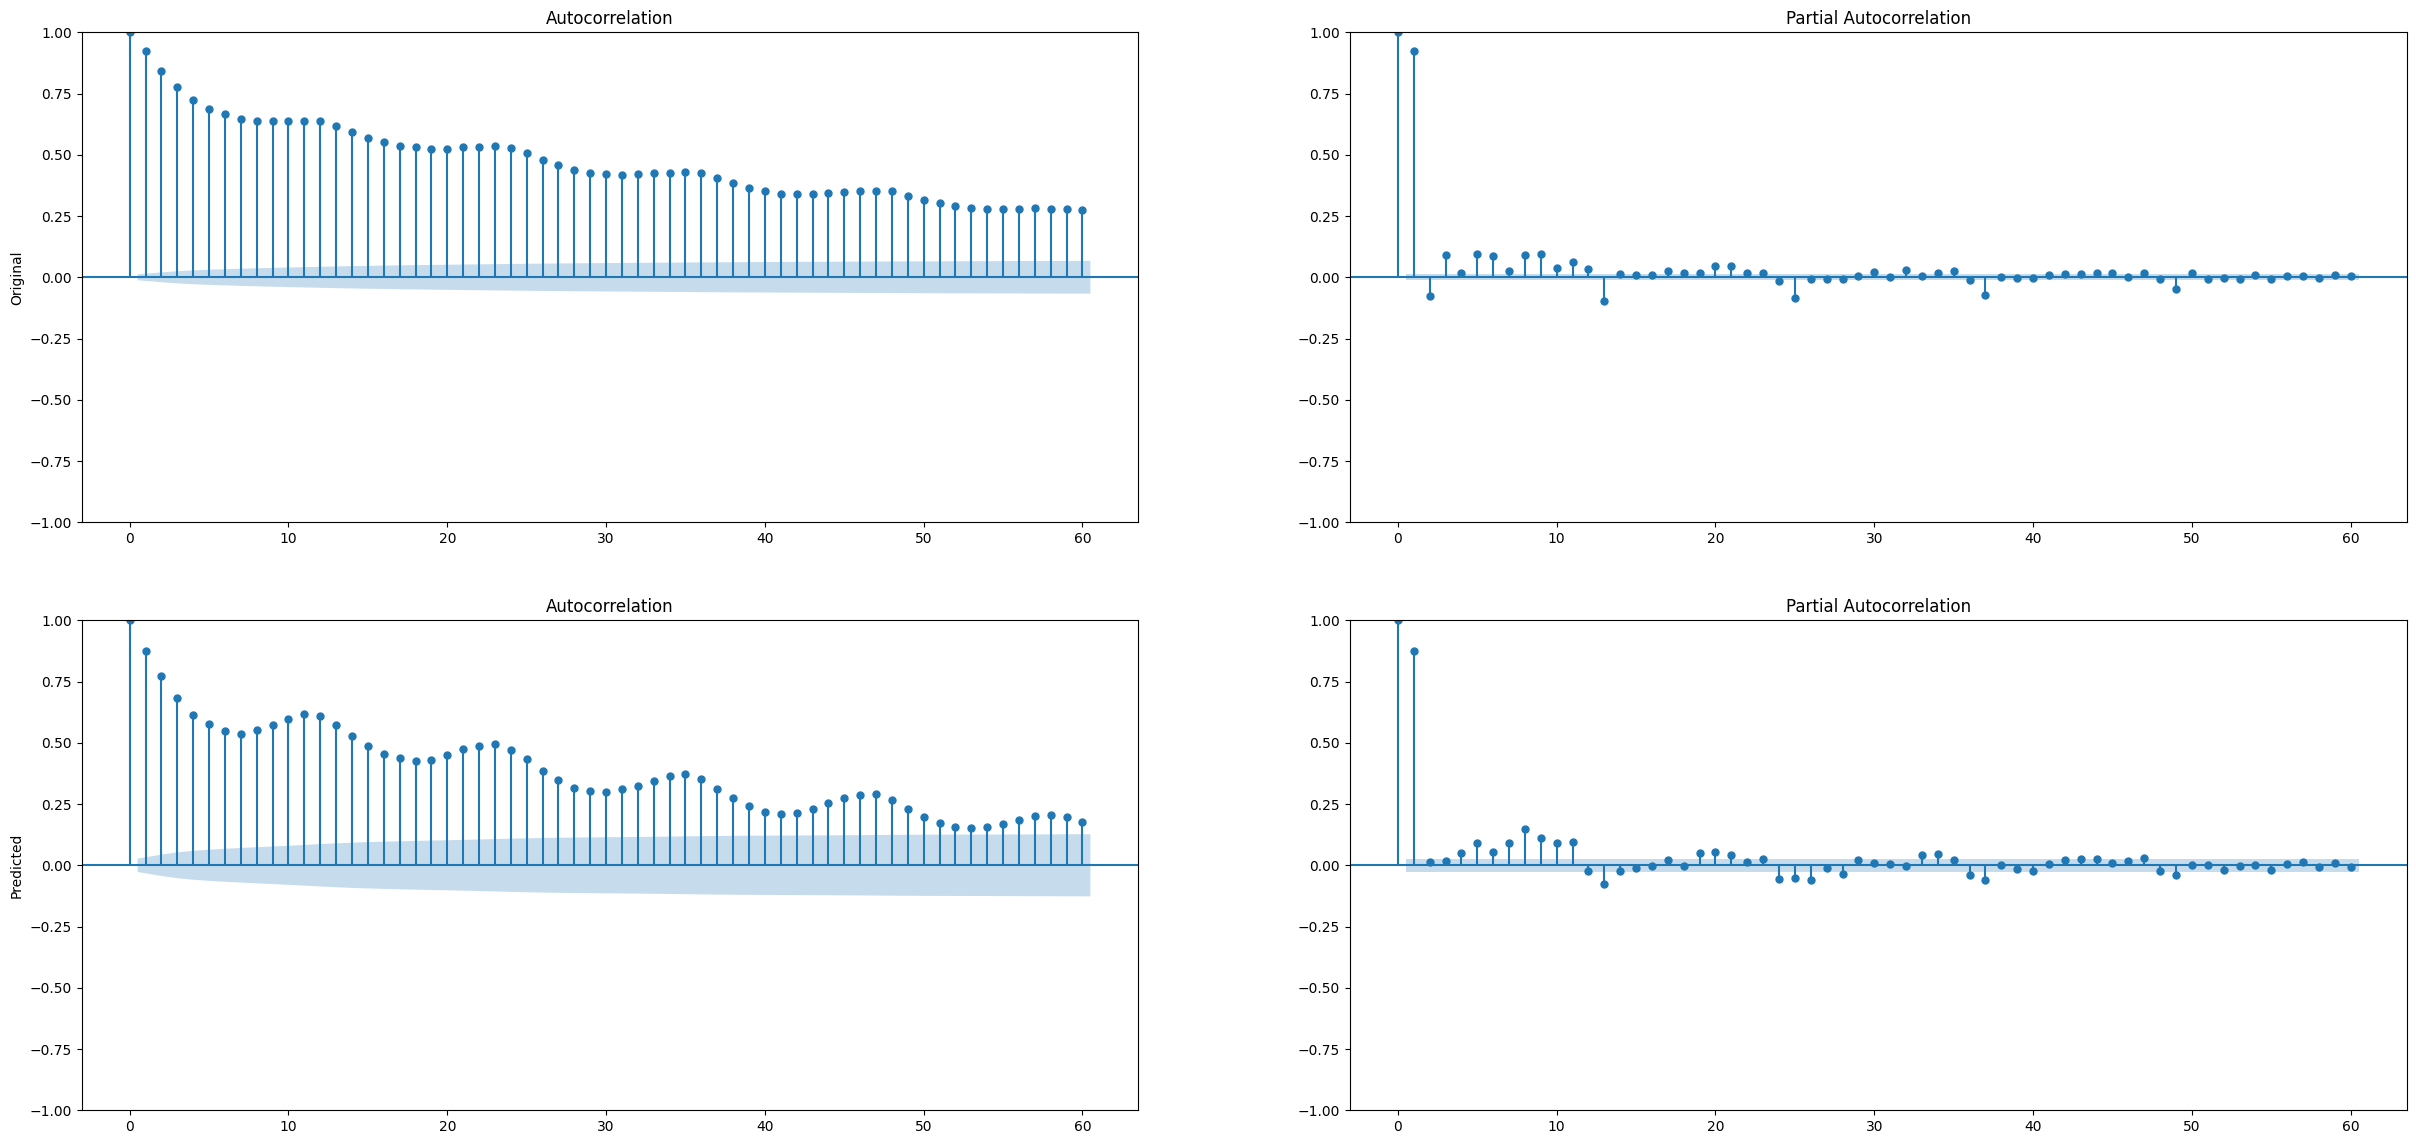

In [30]:
fig, ax = plt.subplots(2,2,figsize=(30,14))
sm.graphics.tsa.plot_acf(series, lags=60, ax=ax[0, 0])
sm.graphics.tsa.plot_pacf(series, lags=60, ax=ax[0, 1])
sm.graphics.tsa.plot_acf(predictions, lags=60, ax=ax[1, 0])
sm.graphics.tsa.plot_pacf(predictions, lags=60, ax=ax[1, 1])
ax[0, 0].set_ylabel("Original")
ax[1, 0].set_ylabel("Predicted")
plt.show()

## ARIMA

In [17]:
model = ARIMA(train, order=(ar_order, 0, ma_order))
if os.path.isfile('models/ARIMA.pkl'):
    model_fit = ARIMAResults.load('models/ARIMA.pkl')
    model_fit.save('ARIMA_new.pkl')
else:
    model_fit = MA_model.fit()

In [18]:
coef = model_fit.params
history = train[len(train)-ar_order:].tolist()

history_ma = train[len(train)-ma_order:].tolist()
pred = model_fit.predict(start=len(train) - ma_order + 1, end=len(train))
# Compute error between actual and prediction
errors = np.array(history_ma - pred).tolist()

predictions = list()
for t in range(len(test)):
    length = len(history)
    yhat = 0
    for d in range(ar_order):
        yhat += coef[d+1] # history[d]

    for d in range(ma_order):
        yhat += coef[d+ar_order+1] # errors[ma_order-d-1]

    errors.pop(0)
    errors.append(test[t] - yhat)
    predictions.append(yhat)
    history.pop(0)
    history.append(test[t])

In [19]:
print_errors(f"ARIMA({ar_order}, 0, {ma_order})", test, predictions)

RMSE for ARIMA(1, 0, 52): 4.193503576621825
MAPE for ARIMA(1, 0, 52): 35.29858347884254
SMAPE for ARIMA(1, 0, 52): 7.349170491810738
MAE for ARIMA(1, 0, 52): 3.528986021206337


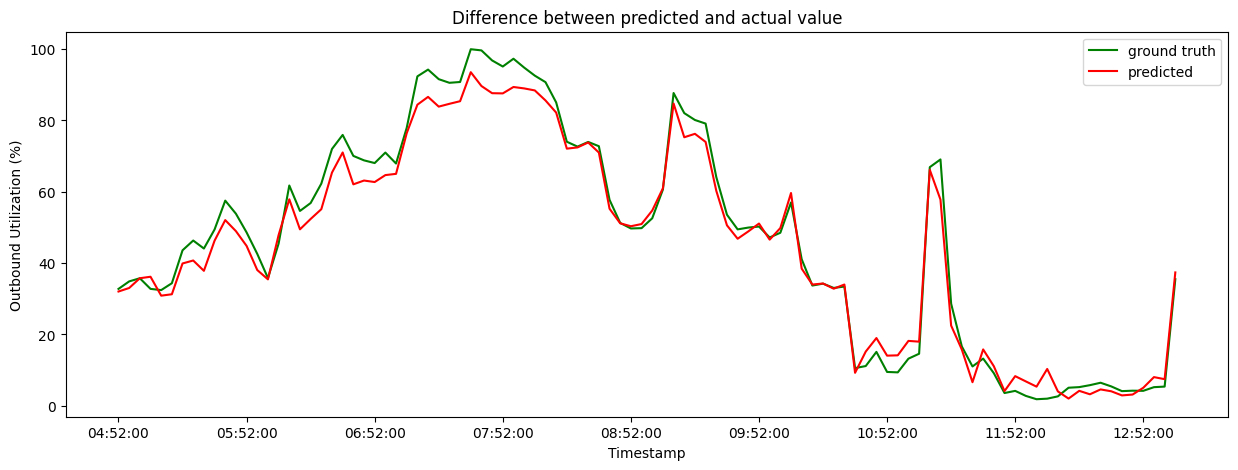

In [20]:
plot_difference(test, predictions)

## CNN

In [21]:
train_len = int(len(network_analytics) * 0.80)
valid_len = int(len(network_analytics) * 0.15)

train = network_analytics[:train_len]
valid = network_analytics[train_len:(train_len + valid_len)]
test = network_analytics[train_len + len(valid):]

assert len(network_analytics) == (len(train) + len(valid) + len(test))

print('Proportion of train_set : {:.2f}%'.format(len(train)/len(network_analytics) * 100))
print('Proportion of valid_set : {:.2f}%'.format(len(valid)/len(network_analytics) * 100))
print('Proportion of test_set : {:.2f}%'.format(len(test)/len(network_analytics) * 100))

Proportion of train_set : 80.00%
Proportion of valid_set : 15.00%
Proportion of test_set : 5.01%


In [22]:
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)

class NetworkAnalyticsDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item, label
    
# https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8489399
class TimeseriesCNN(nn.Module):
    def __init__(self, input_channels) -> None:
        super(TimeseriesCNN,self).__init__()

        self.conv1 = nn.Conv1d(input_channels, 48, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(48, 96, kernel_size=5, padding=2)

        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(96, 20)
        self.fc2 = nn.Linear(20, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = torch.flatten(x, start_dim=1)
        # x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x.squeeze(1)

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

channels = 5

train_data = network_analytics[:train_len]
valid = network_analytics[train_len:(train_len + valid_len)]
test = network_analytics[train_len + len(valid):]

train_x,train_y = split_sequence(train_data['OutboundUtilzation (%)'].values, channels)
valid_x,valid_y = split_sequence(valid['OutboundUtilzation (%)'].values, channels)
test_x,test_y = split_sequence(test['OutboundUtilzation (%)'].values, channels)

model = TimeseriesCNN(channels).to(device)
if os.path.isfile('models/CNN.pt'):
    model.load_state_dict(torch.load('models/CNN.pt', map_location=device))

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

In [24]:
train = NetworkAnalyticsDataset(train_x.reshape(train_x.shape[0],train_x.shape[1], 1), train_y)
valid = NetworkAnalyticsDataset(valid_x.reshape(valid_x.shape[0],valid_x.shape[1], 1), valid_y)
test = NetworkAnalyticsDataset(test_x.reshape(test_x.shape[0],test_x.shape[1], 1), test_y)

train_loader = DataLoader(train, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid, batch_size=1, shuffle=False)
test_loader = DataLoader(test, batch_size=1, shuffle=False)

In [25]:
from copy import deepcopy

best_loss = np.inf
best_model = None
num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        # print(f"{x.shape} {y.shape} {y_pred.shape}")
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    running_loss = .0
    model.eval()
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
    if valid_loss < best_loss:
        print("Epoch %d: best MSE %.4f, new MSE %.4f" % (epoch, best_loss, valid_loss))
        best_loss = valid_loss
        best_model = deepcopy(model)


Epoch 0: best MSE inf, new MSE 60.1719
Epoch 1: best MSE 60.1719, new MSE 47.1801
Epoch 2: best MSE 47.1801, new MSE 46.9570
Epoch 3: best MSE 46.9570, new MSE 45.0054
Epoch 4: best MSE 45.0054, new MSE 44.1756
Epoch 5: best MSE 44.1756, new MSE 43.3739
Epoch 6: best MSE 43.3739, new MSE 43.3176
Epoch 12: best MSE 43.3176, new MSE 43.0881
Epoch 14: best MSE 43.0881, new MSE 42.9660
Epoch 21: best MSE 42.9660, new MSE 42.9154
Epoch 22: best MSE 42.9154, new MSE 42.9059
Epoch 27: best MSE 42.9059, new MSE 42.9050
Epoch 106: best MSE 42.9050, new MSE 42.8674
Epoch 108: best MSE 42.8674, new MSE 42.8388
Epoch 139: best MSE 42.8388, new MSE 42.7990


In [27]:
def test_model(model, loader : DataLoader):
    running_loss = .0
    model.eval()
    predicted = []
    actuals = []
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            predicted.extend(preds.detach().cpu().numpy())
            actuals.extend(labels.detach().cpu().numpy())
            
        test_loss = running_loss/len(loader)
        return test_loss.detach().cpu().numpy(), np.array(predicted), np.array(actuals)

In [28]:
# model = TimeseriesCNN().to(device)
# model.load_state_dict(torch.load("model200.pt", map_location=torch.device('cpu')))
best_model.eval()
torch.save(best_model.state_dict(), 'models/CNN.pt')

loss, predictions, actuals = test_model(best_model, test_loader)
print_errors(f"CNN", actuals, predictions)

RMSE for CNN: 3.8196189578483213
MAPE for CNN: 0.2937425971031189
SMAPE for CNN: 22.244418031458007
MAE for CNN: 3.3698043823242188


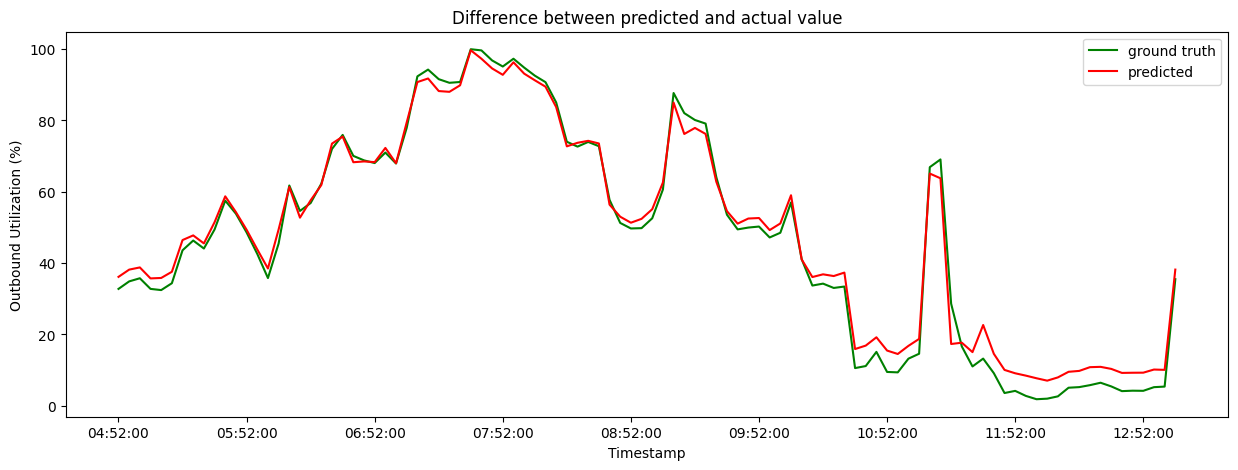

In [29]:
plot_difference(actuals, predictions)

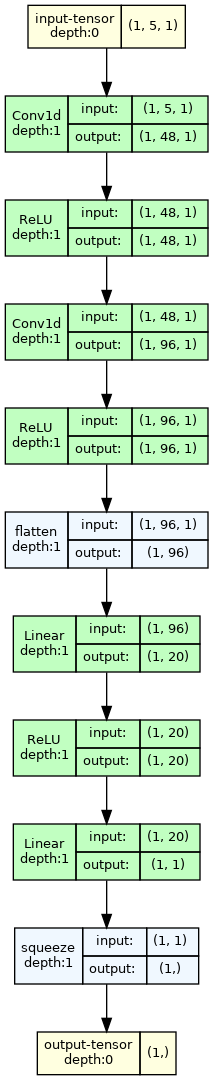

In [31]:
batch = next(iter(test_loader))
yhat = best_model(batch[0].to(device))

model_graph = draw_graph(best_model, input_size=(1,channels,1), expand_nested=True)
model_graph.visual_graph

In [32]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x : torch.Tensor):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

In [33]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+lookback]
        X.append(feature)
        y.append([target])
    return torch.tensor(X, dtype=torch.float32).unsqueeze(1).to(device), torch.tensor(y, dtype=torch.float32).to(device)

In [35]:
input_size = 2
hidden_size = 5
num_layers = 1
output_size = 1


network_analytics = pd.read_csv('/home/ales/DIP/data/Network_Analytics.csv')
network_analytics['Timestamp'] = pd.to_datetime(network_analytics['Timestamp'])
network_analytics = network_analytics.set_index('Timestamp')

X = network_analytics['OutboundUtilzation (%)'].values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]

X_train, y_train = create_dataset(train, lookback=input_size)
X_test, y_test = create_dataset(test, lookback=input_size)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([20502, 1, 2]) torch.Size([20502, 1])
torch.Size([5125, 1, 2]) torch.Size([5125, 1])


In [36]:
learning_rate = 0.001
num_epochs = 100

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
if os.path.isfile('models/LSTM.pt'):
    model.load_state_dict(torch.load('models/LSTM.pt', map_location=device))
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
from copy import deepcopy

best_loss = np.inf
best_model = None

train_loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=64)
test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False, batch_size=1)

for epoch in range(num_epochs):
    running_loss = .0
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)

    # Validation loss
    running_loss = .0
    model.eval()
    predicted = []
    actuals = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            predicted.extend(preds.detach().cpu().numpy())
            actuals.extend(labels.detach().cpu().numpy())
            
        valid_loss = math.sqrt(mean_squared_error(actuals, predicted))
    if valid_loss < best_loss:
        print("Epoch %d: best RMSE %.4f, new RMSE %.4f" % (epoch, best_loss, valid_loss))
        best_loss = valid_loss
        best_model = deepcopy(model)


Epoch 0: best RMSE inf, new RMSE 64.2619
Epoch 1: best RMSE 64.2619, new RMSE 62.7388
Epoch 2: best RMSE 62.7388, new RMSE 61.4790
Epoch 3: best RMSE 61.4790, new RMSE 60.2868
Epoch 4: best RMSE 60.2868, new RMSE 59.1319
Epoch 5: best RMSE 59.1319, new RMSE 58.0041
Epoch 6: best RMSE 58.0041, new RMSE 56.8944
Epoch 7: best RMSE 56.8944, new RMSE 54.9449
Epoch 8: best RMSE 54.9449, new RMSE 53.5500
Epoch 9: best RMSE 53.5500, new RMSE 52.2410
Epoch 10: best RMSE 52.2410, new RMSE 50.9775
Epoch 11: best RMSE 50.9775, new RMSE 49.7437
Epoch 12: best RMSE 49.7437, new RMSE 48.5315
Epoch 13: best RMSE 48.5315, new RMSE 47.3365
Epoch 14: best RMSE 47.3365, new RMSE 46.1576
Epoch 15: best RMSE 46.1576, new RMSE 44.9689
Epoch 16: best RMSE 44.9689, new RMSE 43.8081
Epoch 17: best RMSE 43.8081, new RMSE 42.6516
Epoch 18: best RMSE 42.6516, new RMSE 41.4999
Epoch 19: best RMSE 41.4999, new RMSE 40.3632
Epoch 20: best RMSE 40.3632, new RMSE 39.2371
Epoch 21: best RMSE 39.2371, new RMSE 38.1354
Ep

In [38]:
torch.save(best_model.state_dict(), 'models/LSTM.pt')
best_model.eval()
y_pred = best_model(X_test).detach().cpu().numpy()
y_values = y_test.detach().cpu().numpy()

/home/ales/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


In [39]:
print_errors(f"LSTM", y_values, y_pred)

RMSE for LSTM: 2.948592487056175
MAPE for LSTM: 37.03312301635742
SMAPE for LSTM: 7.779273718804889
MAE for LSTM: 2.2912535667419434


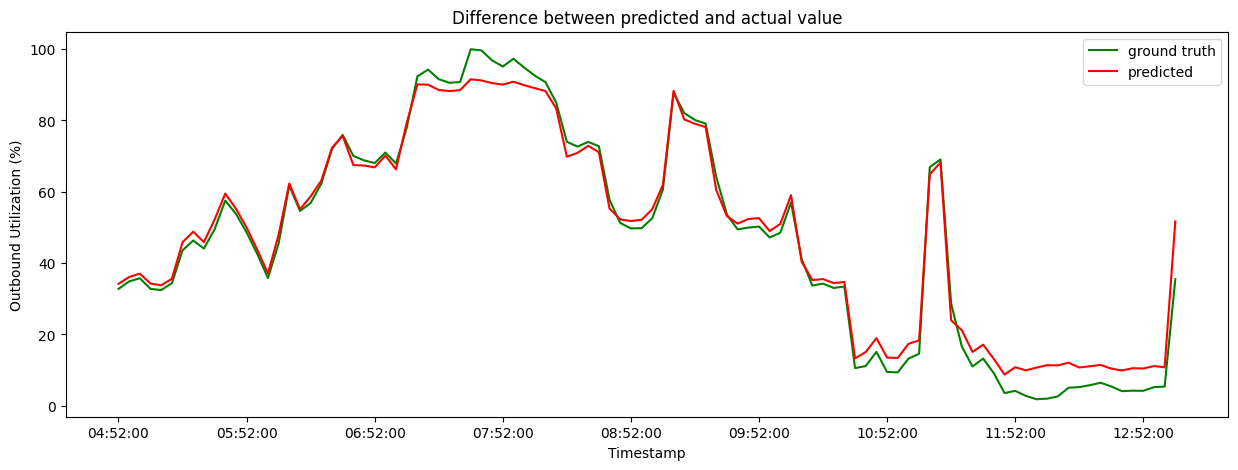

In [40]:
plot_difference(y_values, y_pred)

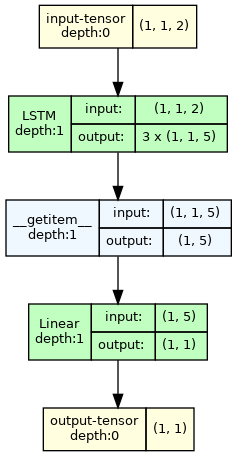

In [41]:
model_graph = draw_graph(model, input_size=(1,1,2), roll=True)
model_graph.visual_graph

In [42]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(GRUModel, self).__init__()
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)

        return out

In [43]:
network_analytics = pd.read_csv('./data/Network_Analytics.csv')
network_analytics['Timestamp'] = pd.to_datetime(network_analytics['Timestamp'])
network_analytics = network_analytics.set_index('Timestamp')

X = network_analytics['OutboundUtilzation (%)'].values
size = int(len(X) * 0.80)
test_size = int(len(X) * 0.01)
train_set, test_set = X[0:size], X[size:len(X)]
train_set, test_set = X[0:size], X[-test_size:len(X)]

input_size = 2
hidden_size = 59
num_layers = 3
output_size = 1

X_train, y_train = create_dataset(train_set, lookback=input_size)
X_test, y_test = create_dataset(test_set, lookback=input_size)


In [44]:
learning_rate = 0.001
num_epochs = 100

model = GRUModel(input_size, hidden_size, num_layers, output_size).to(device)
if os.path.isfile('models/GRU.pt'):
    model.load_state_dict(torch.load('models/GRU.pt', map_location=device))
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
best_loss = np.inf

train_loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=64)
test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False, batch_size=1)

In [45]:
from copy import deepcopy

best_loss = np.inf
best_model = None

for epoch in range(num_epochs):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    running_loss = .0
    model.eval()
    predicted = []
    actuals = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            predicted.extend(preds.detach().cpu().numpy())
            actuals.extend(labels.detach().cpu().numpy())
            
        valid_loss = math.sqrt(mean_squared_error(actuals, predicted))
    if valid_loss < best_loss:
        print("Epoch %d: best RMSE %.4f, new RMSE %.4f" % (epoch, best_loss, valid_loss))
        best_loss = valid_loss
        best_model = deepcopy(model)


Epoch 0: best RMSE inf, new RMSE 27.3860
Epoch 1: best RMSE 27.3860, new RMSE 19.7731
Epoch 2: best RMSE 19.7731, new RMSE 14.7539
Epoch 3: best RMSE 14.7539, new RMSE 12.4047
Epoch 4: best RMSE 12.4047, new RMSE 11.5049
Epoch 5: best RMSE 11.5049, new RMSE 10.9662
Epoch 6: best RMSE 10.9662, new RMSE 10.3543
Epoch 7: best RMSE 10.3543, new RMSE 9.6812
Epoch 8: best RMSE 9.6812, new RMSE 9.5335
Epoch 11: best RMSE 9.5335, new RMSE 9.3539
Epoch 17: best RMSE 9.3539, new RMSE 9.2825
Epoch 22: best RMSE 9.2825, new RMSE 9.2042
Epoch 26: best RMSE 9.2042, new RMSE 9.1059
Epoch 27: best RMSE 9.1059, new RMSE 9.0219
Epoch 30: best RMSE 9.0219, new RMSE 8.9489
Epoch 65: best RMSE 8.9489, new RMSE 8.9172
Epoch 85: best RMSE 8.9172, new RMSE 8.8759


In [46]:
torch.save(best_model.state_dict(), 'models/GRU.pt')
best_model.eval()
y_pred = best_model(X_test).detach().cpu().numpy()
y_pred = y_pred# [:, -1, :]
y_values = y_test.detach().cpu().numpy()# [:, -1, :]

/home/ales/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:1100: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


In [47]:
print_errors(f"GRU", y_values, y_pred)

RMSE for GRU: 3.760601951423248
MAPE for GRU: 0.423295795917511
SMAPE for GRU: 29.51333569914927
MAE for GRU: 3.1958770751953125


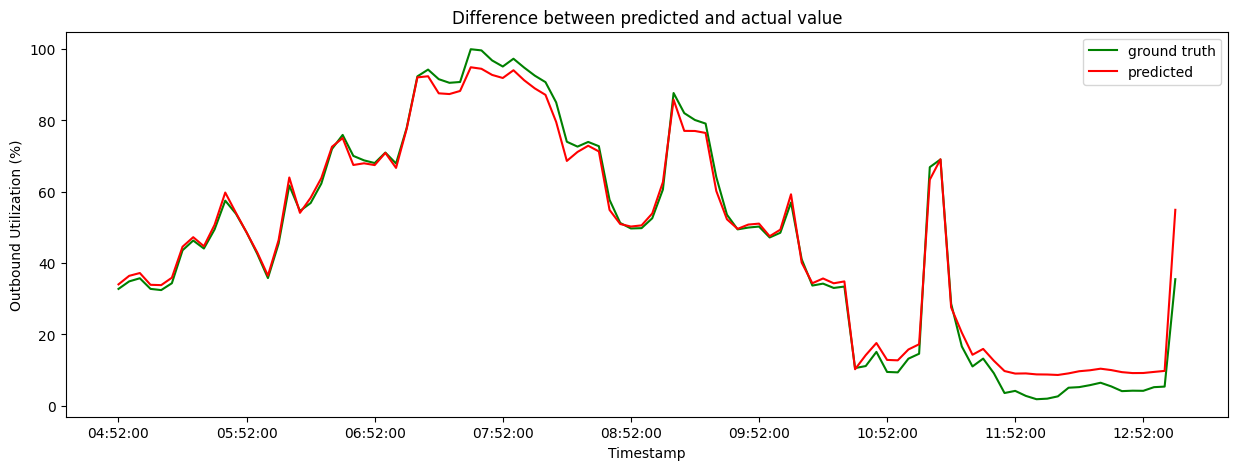

In [48]:
plot_difference(y_values, y_pred)

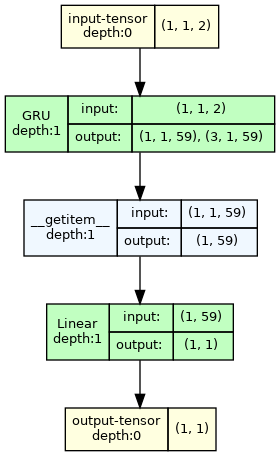

In [50]:
model_graph = draw_graph(model, input_size=(1,1,2), roll=True)
model_graph.visual_graph